<a href="https://colab.research.google.com/github/kzumreen/FoodTrendsPrediction/blob/main/Reddit_Access.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Reddit API EDA
This notebook pulls data from Reddit API via PRAW and its respective exploratory data analysis.

In [1]:
!pip install praw pandas

In [2]:
from google.colab import userdata
import praw
import time
import pandas as pd

In [3]:
CLIENT_ID = userdata.get("REDDIT_CLIENT_ID")
CLIENT_SECRET = userdata.get("REDDIT_CLIENT_SECRET")
USER_AGENT = userdata.get("REDDIT_USER_AGENT")

In [4]:
try:
    reddit = praw.Reddit(
        client_id=CLIENT_ID,
        client_secret=CLIENT_SECRET,
        user_agent=USER_AGENT
    )
    print("PRAW connection successful. Operating in read-only mode.")
except Exception as e:
    print(f"An error occurred during PRAW initialization: {e}")
    reddit = None

PRAW connection successful. Operating in read-only mode.


In [5]:
TREND_MAP = {
    'feta-pasta': ['feta pasta', 'baked feta', 'tiktok pasta', 'viral pasta',
                   'feta tomato pasta', 'baked feta tomato'],
    'matcha': ['matcha', 'matcha latte', 'matcha powder', 'matcha tea',
               'ceremonial matcha', 'matcha recipe', 'iced matcha'],
    'dubai-chocolate': ['dubai chocolate', 'knafeh chocolate', 'fix chocolate',
                        'pistachio chocolate', 'viral chocolate', 'kadayif chocolate'],
    'cottage-cheese': ['cottage cheese', 'cottage cheese ice cream',
                       'cottage cheese recipe', 'high protein cottage'],
    'air-fryer': ['air fryer', 'air fried', 'airfryer recipe', 'air fryer cooking'],
    'crumbl': ['crumbl cookie', 'crumbl', 'giant cookie', 'crumbl copycat']
}

In [6]:
# BASELINE (non-trending) foods for comparison
BASELINE_MAP = {
    'pizza': ['pizza', 'pepperoni pizza', 'homemade pizza'],
    'chicken': ['chicken breast', 'grilled chicken', 'chicken recipe'],
    'salad': ['salad', 'caesar salad', 'green salad'],
    'pasta-general': ['pasta', 'spaghetti', 'marinara', 'pasta recipe']
}

In [7]:
TARGET_SUBREDDITS = [
    # Original subreddits
    'food', 'cooking', 'recipes', 'baking', 'streetfood',
    'easyrecipes', 'snacksindia', 'askUK', 'candy', 'chocolate',
    'UAE', 'seriouseats', 'RecipeInspiration', 'unpopularopinion',
    'uk_food', 'cookingtonight', 'pasta', 'foodhack', 'nutrition',
    'vegetarianrecipes', 'foodvideos', 'budgetcooking', 'dessertporn',
    'junkfoodfinds', 'popculturechat', 'tea', 'shittyfoodporn',
    'snacks', 'foodlosangeles', 'stupidfood', 'TikTokTrends',
    'TikTokCringe',

    # NEW ADDITIONS - High-value subreddits for trend analysis
    'TikTokFood',
    'GifRecipes',
    'MealPrepSunday',
    '1200isplenty',
    'EatCheapAndHealthy',
    'ketorecipes',
    'veganrecipes',
    'FoodPorn',
    'HealthyFood',
    'fitmeals',
    'Bento',
    'DessertPorn',
    'IceCreamery',
    'Coffee',
    'CasualConversation'
]

print(f"✓ Defined {len(TREND_MAP)} trend categories")
print(f"✓ Defined {len(BASELINE_MAP)} baseline categories")
print(f"✓ Targeting {len(TARGET_SUBREDDITS)} subreddits")

✓ Defined 6 trend categories
✓ Defined 4 baseline categories
✓ Targeting 47 subreddits


In [8]:
def search_reddit_globally(keywords, time_filter='year', limit=500):
    """
    Search across ALL of Reddit for specific keywords
    This is CRITICAL for finding trend-specific posts
    """
    all_reddit = reddit.subreddit('all')
    posts_data = []

    for keyword in keywords:
        print(f"  → Searching all of Reddit for '{keyword}'...")
        try:
            for submission in all_reddit.search(keyword, time_filter=time_filter, limit=limit):
                posts_data.append({
                    'id': submission.id,
                    'subreddit': str(submission.subreddit),
                    'title': submission.title,
                    'score': submission.score,
                    'num_comments': submission.num_comments,
                    'author': str(submission.author),
                    'url': submission.url,
                    'created_utc': submission.created_utc,
                    'search_keyword': keyword
                })
        except Exception as e:
            print(f"    ✗ Error searching for '{keyword}': {e}")
            continue

        time.sleep(2)  # Rate limiting

    return posts_data



In [9]:
def get_subreddit_top_posts(subreddit_name, limit=200):
    """
    Get top posts from a subreddit (multiple time periods)
    """
    posts_data = []

    try:
        subreddit = reddit.subreddit(subreddit_name)

        # Get top posts from different time periods
        for time_filter in ['year', 'month']:
            for submission in subreddit.top(time_filter=time_filter, limit=limit):
                posts_data.append({
                    'id': submission.id,
                    'subreddit': subreddit_name,
                    'title': submission.title,
                    'score': submission.score,
                    'num_comments': submission.num_comments,
                    'author': str(submission.author),
                    'url': submission.url,
                    'created_utc': submission.created_utc,
                    'search_keyword': 'top_posts'
                })
            time.sleep(1)

    except Exception as e:
        print(f"  ✗ Error fetching from r/{subreddit_name}: {e}")

    return posts_data

In [10]:
def get_subreddit_new_posts(subreddit_name, limit=500):
    """
    Get newest posts from a subreddit
    """
    posts_data = []

    try:
        subreddit = reddit.subreddit(subreddit_name)

        for submission in subreddit.new(limit=limit):
            posts_data.append({
                'id': submission.id,
                'subreddit': subreddit_name,
                'title': submission.title,
                'score': submission.score,
                'num_comments': submission.num_comments,
                'author': str(submission.author),
                'url': submission.url,
                'created_utc': submission.created_utc,
                'search_keyword': 'new_posts'
            })

    except Exception as e:
        print(f"  ✗ Error fetching new posts from r/{subreddit_name}: {e}")

    return posts_data

In [11]:
def remove_duplicates(posts_list):
    """
    Remove duplicate posts based on ID
    """
    seen_ids = set()
    unique_posts = []

    for post in posts_list:
        if post['id'] not in seen_ids:
            seen_ids.add(post['id'])
            unique_posts.append(post)

    return unique_posts


In [12]:
print("=" * 70)
print("PHASE 1: GLOBAL TREND SEARCH")
print("=" * 70)

all_trend_posts = []

# Collect data for each TREND
for trend_id, keywords in TREND_MAP.items():
    print(f"\n📊 Collecting data for: {trend_id.upper()}")

    # Global search across all Reddit
    trend_posts = search_reddit_globally(keywords, time_filter='all', limit=500)

    # Add trend identifier
    for post in trend_posts:
        post['trend_category'] = trend_id
        post['is_baseline'] = False

    all_trend_posts.extend(trend_posts)
    print(f"  ✓ Found {len(trend_posts)} posts for {trend_id}")

    time.sleep(3)  # Rate limiting

# Remove duplicates
all_trend_posts = remove_duplicates(all_trend_posts)

print(f"\n{'='*70}")
print(f"✓ PHASE 1 COMPLETE: Collected {len(all_trend_posts)} unique trend posts")
print(f"{'='*70}")


print("\n" + "=" * 70)
print("PHASE 2: BASELINE FOOD SEARCH")
print("=" * 70)

all_baseline_posts = []

# Collect data for each BASELINE food
for baseline_id, keywords in BASELINE_MAP.items():
    print(f"\n📊 Collecting baseline data for: {baseline_id.upper()}")

    # Global search with smaller limit
    baseline_posts = search_reddit_globally(keywords, time_filter='year', limit=200)

    # Add baseline identifier
    for post in baseline_posts:
        post['trend_category'] = baseline_id
        post['is_baseline'] = True

    all_baseline_posts.extend(baseline_posts)
    print(f"  ✓ Found {len(baseline_posts)} posts for {baseline_id}")

    time.sleep(3)

# Remove duplicates
all_baseline_posts = remove_duplicates(all_baseline_posts)

print(f"\n{'='*70}")
print(f"✓ PHASE 2 COMPLETE: Collected {len(all_baseline_posts)} unique baseline posts")
print(f"{'='*70}")


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



PHASE 1: GLOBAL TREND SEARCH

📊 Collecting data for: FETA-PASTA
  → Searching all of Reddit for 'feta pasta'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'baked feta'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'tiktok pasta'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'viral pasta'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'feta tomato pasta'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'baked feta tomato'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Found 1299 posts for feta-pasta


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting data for: MATCHA
  → Searching all of Reddit for 'matcha'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'matcha latte'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'matcha powder'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'matcha tea'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'ceremonial matcha'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'matcha recipe'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'iced matcha'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Found 1698 posts for matcha


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting data for: DUBAI-CHOCOLATE
  → Searching all of Reddit for 'dubai chocolate'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'knafeh chocolate'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'fix chocolate'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'pistachio chocolate'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'viral chocolate'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'kadayif chocolate'...
  ✓ Found 1241 posts for dubai-chocolate


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting data for: COTTAGE-CHEESE
  → Searching all of Reddit for 'cottage cheese'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'cottage cheese ice cream'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'cottage cheese recipe'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'high protein cottage'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Found 958 posts for cottage-cheese


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting data for: AIR-FRYER
  → Searching all of Reddit for 'air fryer'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'air fried'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'airfryer recipe'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'air fryer cooking'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Found 904 posts for air-fryer


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting data for: CRUMBL
  → Searching all of Reddit for 'crumbl cookie'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'crumbl'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'giant cookie'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'crumbl copycat'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Found 938 posts for crumbl


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




✓ PHASE 1 COMPLETE: Collected 6232 unique trend posts

PHASE 2: BASELINE FOOD SEARCH

📊 Collecting baseline data for: PIZZA
  → Searching all of Reddit for 'pizza'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'pepperoni pizza'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'homemade pizza'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Found 600 posts for pizza


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting baseline data for: CHICKEN
  → Searching all of Reddit for 'chicken breast'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'grilled chicken'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'chicken recipe'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Found 600 posts for chicken


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting baseline data for: SALAD
  → Searching all of Reddit for 'salad'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'caesar salad'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'green salad'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Found 600 posts for salad


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting baseline data for: PASTA-GENERAL
  → Searching all of Reddit for 'pasta'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'spaghetti'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'marinara'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'pasta recipe'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Found 800 posts for pasta-general

✓ PHASE 2 COMPLETE: Collected 2448 unique baseline posts


In [13]:
print("\n" + "=" * 70)
print("PHASE 3: SUBREDDIT-SPECIFIC COLLECTION")
print("=" * 70)

all_subreddit_posts = []

for subreddit_name in TARGET_SUBREDDITS:
    print(f"\n📊 Collecting from r/{subreddit_name}")

    # Get top posts
    top_posts = get_subreddit_top_posts(subreddit_name, limit=100)

    # Get new posts
    new_posts = get_subreddit_new_posts(subreddit_name, limit=200)

    # Combine and mark as subreddit collection
    sub_posts = top_posts + new_posts
    for post in sub_posts:
        post['trend_category'] = 'subreddit_general'
        post['is_baseline'] = False

    all_subreddit_posts.extend(sub_posts)
    print(f"  ✓ Collected {len(sub_posts)} posts from r/{subreddit_name}")

    time.sleep(2)  # Rate limiting

# Remove duplicates
all_subreddit_posts = remove_duplicates(all_subreddit_posts)

print(f"\n{'='*70}")
print(f"✓ PHASE 3 COMPLETE: Collected {len(all_subreddit_posts)} unique subreddit posts")
print(f"{'='*70}")


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




PHASE 3: SUBREDDIT-SPECIFIC COLLECTION

📊 Collecting from r/food


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/food


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/cooking


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/cooking


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/recipes


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 343 posts from r/recipes


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/baking


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/baking


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/streetfood


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 226 posts from r/streetfood


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/easyrecipes


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 333 posts from r/easyrecipes


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/snacksindia


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/snacksindia


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/askUK


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/askUK


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/candy


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/candy


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/chocolate


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/chocolate


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/UAE


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/UAE


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/seriouseats


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 334 posts from r/seriouseats


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/RecipeInspiration


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/RecipeInspiration


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/unpopularopinion


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/unpopularopinion


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/uk_food


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/uk_food


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/cookingtonight


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/cookingtonight


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/pasta


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/pasta


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/foodhack


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 261 posts from r/foodhack


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/nutrition


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/nutrition


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/vegetarianrecipes


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 369 posts from r/vegetarianrecipes


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/foodvideos


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 326 posts from r/foodvideos


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/budgetcooking


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 324 posts from r/budgetcooking


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/dessertporn


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/dessertporn


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/junkfoodfinds


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/junkfoodfinds


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/popculturechat


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/popculturechat


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/tea


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/tea


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/shittyfoodporn


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/shittyfoodporn


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/snacks


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 392 posts from r/snacks


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/foodlosangeles


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/foodlosangeles


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/stupidfood


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/stupidfood


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/TikTokTrends


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 144 posts from r/TikTokTrends


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/TikTokCringe


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/TikTokCringe


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/TikTokFood


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 53 posts from r/TikTokFood


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/GifRecipes


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 330 posts from r/GifRecipes


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/MealPrepSunday


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/MealPrepSunday


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/1200isplenty


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/1200isplenty


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/EatCheapAndHealthy


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/EatCheapAndHealthy


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/ketorecipes


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 351 posts from r/ketorecipes


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/veganrecipes


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/veganrecipes


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/FoodPorn


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/FoodPorn


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/HealthyFood


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 262 posts from r/HealthyFood


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/fitmeals


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 364 posts from r/fitmeals


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/Bento


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 394 posts from r/Bento


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/DessertPorn


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/DessertPorn


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/IceCreamery


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/IceCreamery


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/Coffee


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 375 posts from r/Coffee


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/CasualConversation


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/CasualConversation

✓ PHASE 3 COMPLETE: Collected 13913 unique subreddit posts


In [14]:
# Combine all posts
all_posts = all_trend_posts + all_baseline_posts + all_subreddit_posts

# Remove final duplicates
all_posts = remove_duplicates(all_posts)

# Create DataFrame
df = pd.DataFrame(all_posts)

print(f"\n✓ Total unique posts collected: {len(df)}")
print(f"✓ Date range: {len(df)} posts")

# Display breakdown
print(" Data Breakdown:")
print(df['trend_category'].value_counts())



✓ Total unique posts collected: 22374
✓ Date range: 22374 posts
 Data Breakdown:
trend_category
subreddit_general    13728
matcha                1528
dubai-chocolate       1146
feta-pasta             942
crumbl                 899
cottage-cheese         877
air-fryer              840
pasta-general          751
chicken                560
salad                  559
pizza                  544
Name: count, dtype: int64


In [15]:
df['date'] = pd.to_datetime(df['created_utc'], unit='s', utc=True)

# Sort by date (newest first)
df = df.sort_values(by='date', ascending=False)

# Filter to 2015 onwards
START_YEAR = 2015
df = df[df['date'].dt.year >= START_YEAR].copy()

# ============================================================================
# CREATE THE STANDARDIZED "Date" COLUMN (PER SPECS)
# ============================================================================
# Specification Requirements:
# - Column Name: "Date" (exact spelling and casing)
# - Data Type: DateTime object
# - Format: YYYY-MM-DD (no time component)
# - Frequency: Daily time series

# Step 1: Extract YYYY-MM-DD (no time component)
df['Date'] = pd.to_datetime(df['date'].dt.date)

print(f"\n✓ Created 'Date' column:")
print(f"   - Column name: 'Date' (matches spec ✓)")
print(f"   - Data type: {df['Date'].dtype}")
print(f"   - Format: YYYY-MM-DD ✓")
print(f"   - Sample values:\n{df['Date'].head()}")

print(f"\n✓ Data filtered: {len(df)} posts from {START_YEAR} to present")
print(f"✓ Date range: {df['Date'].min()} to {df['Date'].max()}")


# ============================================================================
# CELL 10: ASSIGN TREND IDs (Improved matching)
# ============================================================================

# Initialize Trend_ID column
df['Trend_ID'] = 'other'

# Create regex patterns for better matching
def create_keyword_pattern(keywords):
    """Create a regex pattern from keyword list"""
    return '|'.join([kw.lower() for kw in keywords])

# Assign Trend IDs based on title matching
for trend_id, keywords in TREND_MAP.items():
    pattern = create_keyword_pattern(keywords)
    mask = (df['title'].str.contains(pattern, case=False, na=False)) & \
           (df['Trend_ID'] == 'other')
    df.loc[mask, 'Trend_ID'] = trend_id
    print(f"  ✓ Assigned {mask.sum()} posts to {trend_id}")

# Assign baseline IDs
for baseline_id, keywords in BASELINE_MAP.items():
    pattern = create_keyword_pattern(keywords)
    mask = (df['title'].str.contains(pattern, case=False, na=False)) & \
           (df['Trend_ID'] == 'other') & \
           (df['is_baseline'] == True)
    df.loc[mask, 'Trend_ID'] = baseline_id
    print(f"  ✓ Assigned {mask.sum()} posts to baseline: {baseline_id}")

print(f"\n📊 Final Trend ID Distribution:")
print(df['Trend_ID'].value_counts())


✓ Created 'Date' column:
   - Column name: 'Date' (matches spec ✓)
   - Data type: datetime64[ns]
   - Format: YYYY-MM-DD ✓
   - Sample values:
22187   2025-10-20
20551   2025-10-20
22188   2025-10-20
14050   2025-10-20
16557   2025-10-20
Name: Date, dtype: datetime64[ns]

✓ Data filtered: 22363 posts from 2015 to present
✓ Date range: 2015-01-04 00:00:00 to 2025-10-20 00:00:00
  ✓ Assigned 290 posts to feta-pasta
  ✓ Assigned 1441 posts to matcha
  ✓ Assigned 447 posts to dubai-chocolate
  ✓ Assigned 521 posts to cottage-cheese
  ✓ Assigned 636 posts to air-fryer
  ✓ Assigned 642 posts to crumbl
  ✓ Assigned 542 posts to baseline: pizza
  ✓ Assigned 264 posts to baseline: chicken
  ✓ Assigned 483 posts to baseline: salad
  ✓ Assigned 615 posts to baseline: pasta-general

📊 Final Trend ID Distribution:
Trend_ID
other              16482
matcha              1441
crumbl               642
air-fryer            636
pasta-general        615
pizza                542
cottage-cheese       521
s

In [16]:
print("\n" + "=" * 70)
print("DATA QUALITY CHECK")
print("=" * 70)

print("\n1. Dataset Shape:")
print(f"   Rows: {df.shape[0]}, Columns: {df.shape[1]}")

print("\n2. Date Range:")
print(f"   Earliest: {df['date'].min()}")
print(f"   Latest: {df['date'].max()}")

print("\n3. Missing Values:")
print(df.isnull().sum())

print("\n4. Numerical Summary:")
print(df[['score', 'num_comments']].describe())

print("\n5. Top 5 Subreddits:")
print(df['subreddit'].value_counts().head())

print("\n6. Sample Data:")
print(df[['title', 'subreddit', 'Trend_ID', 'date', 'score']].head(10))

# Check trend coverage
print("\n7. Trend Post Counts:")
for trend in TREND_MAP.keys():
    count = len(df[df['Trend_ID'] == trend])
    print(f"   {trend}: {count} posts")



DATA QUALITY CHECK

1. Dataset Shape:
   Rows: 22363, Columns: 14

2. Date Range:
   Earliest: 2015-01-04 13:42:22+00:00
   Latest: 2025-10-20 02:46:28+00:00

3. Missing Values:
id                0
subreddit         0
title             0
score             0
num_comments      0
author            0
url               0
created_utc       0
search_keyword    0
trend_category    0
is_baseline       0
date              0
Date              0
Trend_ID          0
dtype: int64

4. Numerical Summary:
               score  num_comments
count   22363.000000  22363.000000
mean     2206.150695    183.245987
std      8102.040773    626.367363
min         0.000000      0.000000
25%         9.000000      5.000000
50%       112.000000     23.000000
75%       843.000000    102.000000
max    207314.000000  22735.000000

5. Top 5 Subreddits:
subreddit
food              632
shittyfoodporn    494
tea               477
1200isplenty      412
FoodPorn          404
Name: count, dtype: int64

6. Sample Data:
     

In [17]:
from google.colab import drive
drive.mount('/content/drive')

# Save main dataset
df.to_csv('/content/drive/MyDrive/reddit_food_trends_complete.csv', index=False)
print("✓ Saved: reddit_food_trends_complete.csv")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Saved: reddit_food_trends_complete.csv


In [18]:
for trend in TREND_MAP.keys():
    trend_df = df[df['Trend_ID'] == trend]
    if len(trend_df) > 0:
        filename = f'/content/drive/MyDrive/reddit_{trend}_data.csv'
        trend_df.to_csv(filename, index=False)
        print(f"Saved: reddit_{trend}_data.csv ({len(trend_df)} posts)")



Saved: reddit_feta-pasta_data.csv (290 posts)
Saved: reddit_matcha_data.csv (1441 posts)
Saved: reddit_dubai-chocolate_data.csv (447 posts)
Saved: reddit_cottage-cheese_data.csv (521 posts)
Saved: reddit_air-fryer_data.csv (636 posts)
Saved: reddit_crumbl_data.csv (642 posts)


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats


In [20]:
CUSTOM_COLORS = {
    'dubai-chocolate': '#3A1F04',
    'feta-pasta': '#B90E0A',
    'matcha': '#32612D',
    'airfryer': '#D2691E',

    # Baseline colors (grays)
    'pizza': '#696969',
    'chicken': '#808080',
    'salad': '#A9A9A9',
    'pasta-general': '#C0C0C0'
}

In [21]:
#colormaps_for_trends = ['BrBG', 'Greens', 'Reds'] # Brown, Green, Red shades
#masks = [None, None, None] # Set to None for default rectangular shape

⚠ Skipping airfryer: only 0 posts


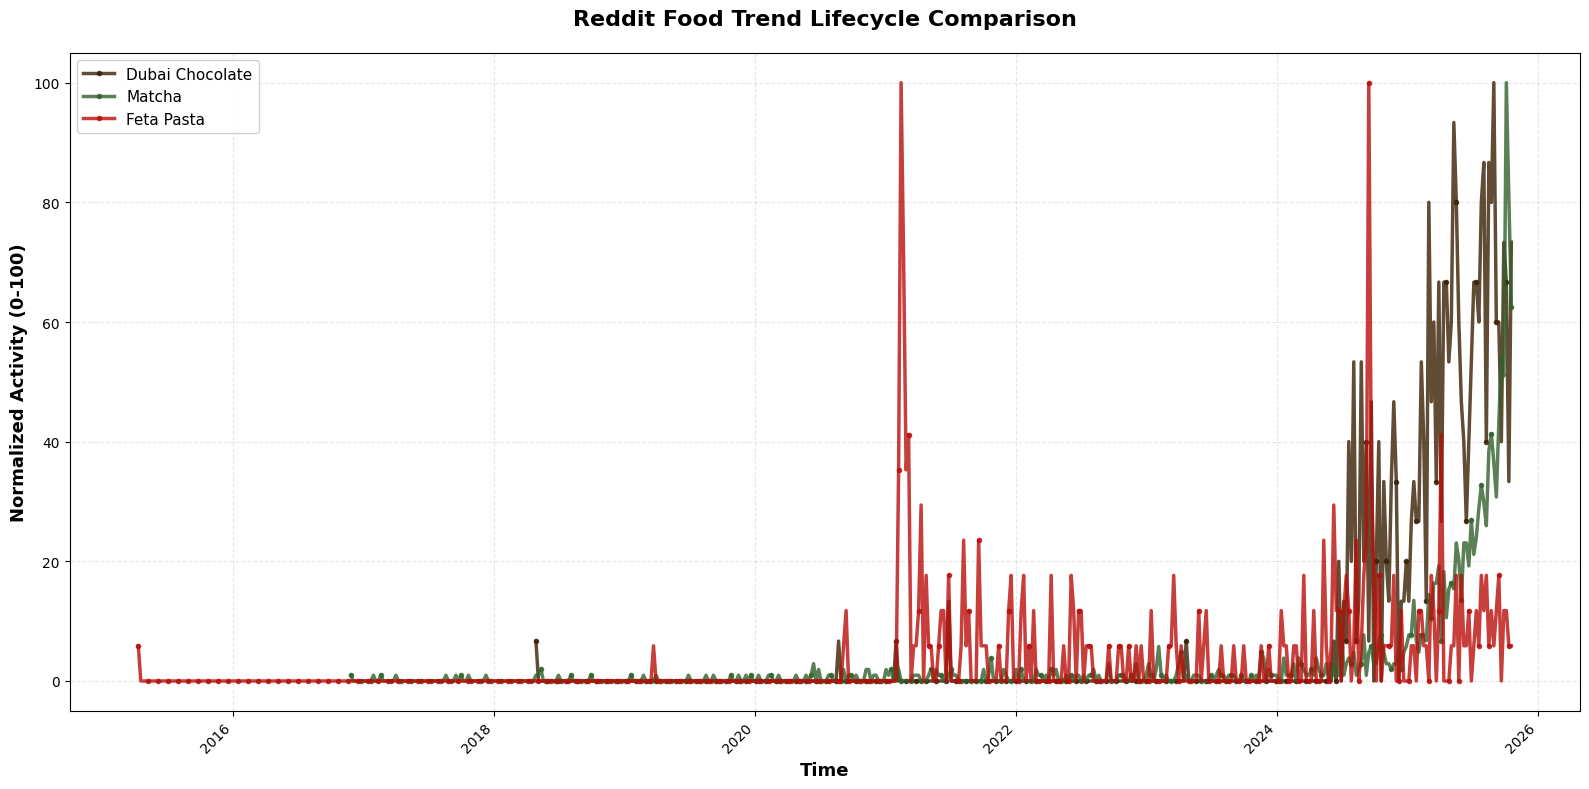

In [22]:
def plot_normalized_trends(df, trends_to_plot=None):
    """
    Shows all trends on normalized scale (0-100) to compare growth patterns
    """
    if trends_to_plot is None:
        trends_to_plot = ['dubai-chocolate', 'matcha', 'feta-pasta', 'airfryer']

    fig, ax = plt.subplots(figsize=(16, 8))

    for trend in trends_to_plot:
        trend_df = df[df['Trend_ID'] == trend].copy()

        if len(trend_df) < 10:  # Skip if too few posts
            print(f"⚠ Skipping {trend}: only {len(trend_df)} posts")
            continue

        # Weekly aggregation
        weekly_counts = (trend_df.set_index('Date')
                        .resample('W')
                        .size()
                        .reset_index(name='count'))

        # Normalize to 0-100 scale
        if weekly_counts['count'].max() > 0:
            weekly_counts['normalized'] = (
                (weekly_counts['count'] - weekly_counts['count'].min()) /
                (weekly_counts['count'].max() - weekly_counts['count'].min()) * 100
            )

            ax.plot(weekly_counts['Date'],
                   weekly_counts['normalized'],
                   label=trend.replace('-', ' ').title(),
                   color=CUSTOM_COLORS.get(trend, 'gray'),
                   linewidth=2.5,
                   alpha=0.8,
                   marker='o',
                   markersize=3,
                   markevery=4)

    ax.set_xlabel('Time', fontsize=13, fontweight='bold')
    ax.set_ylabel('Normalized Activity (0-100)', fontsize=13, fontweight='bold')
    ax.set_title('Reddit Food Trend Lifecycle Comparison',
                 fontsize=16, fontweight='bold', pad=20)
    ax.legend(fontsize=11, loc='best', framealpha=0.9)
    ax.grid(True, alpha=0.3, linestyle='--')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Run the plot
plot_normalized_trends(df)

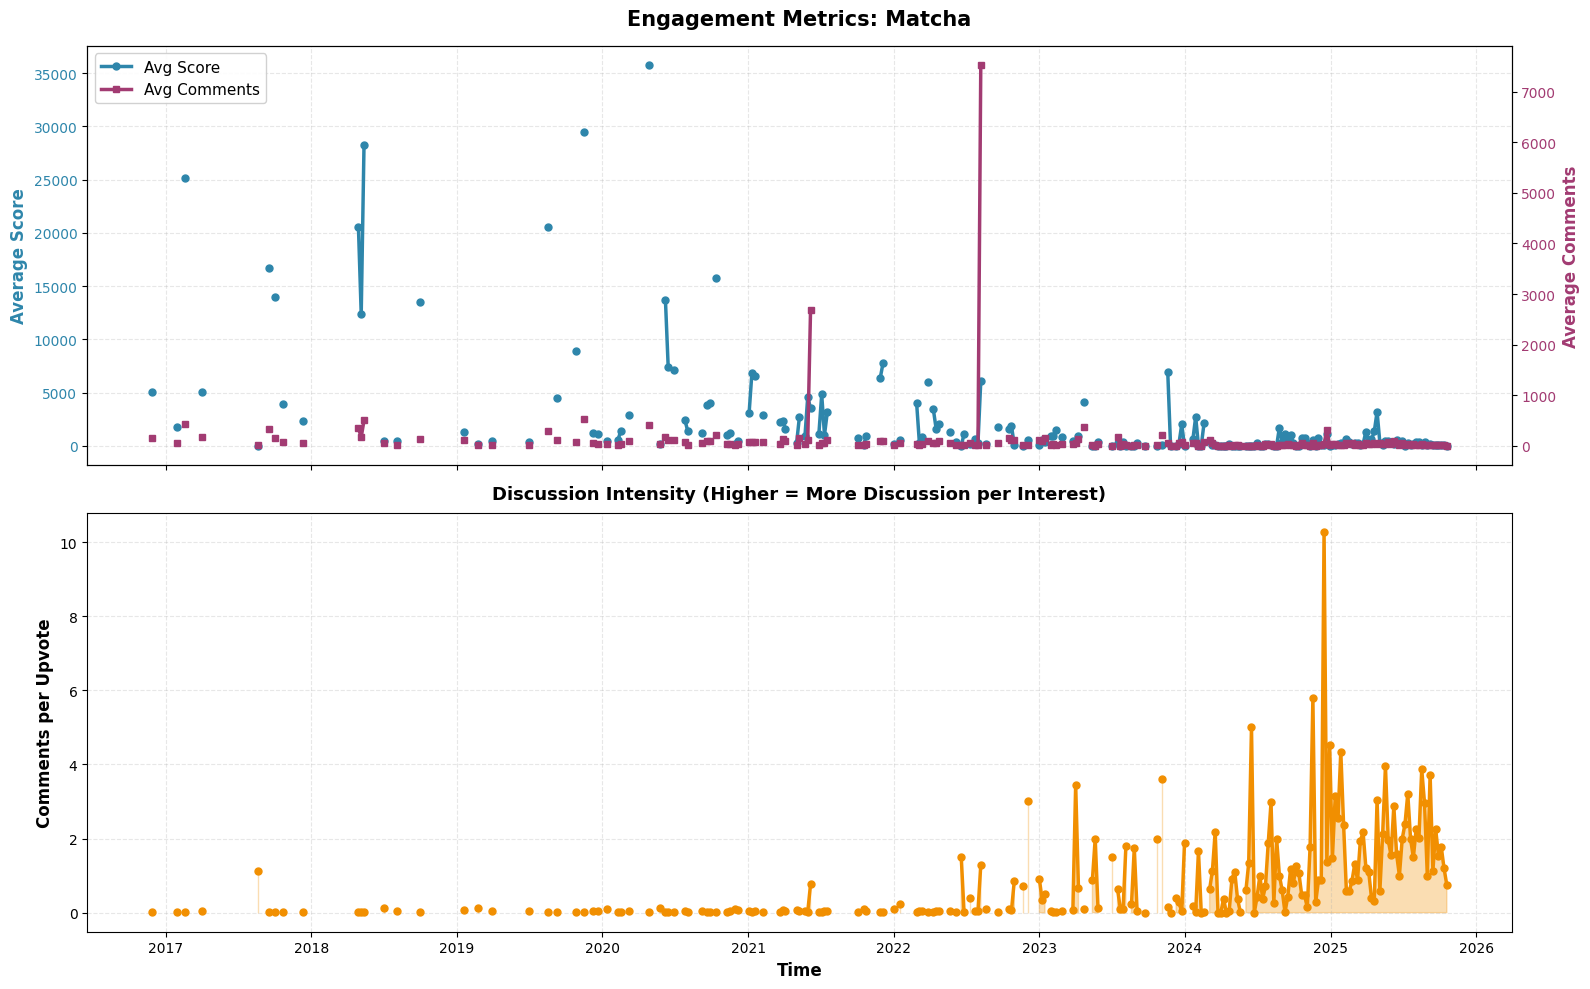

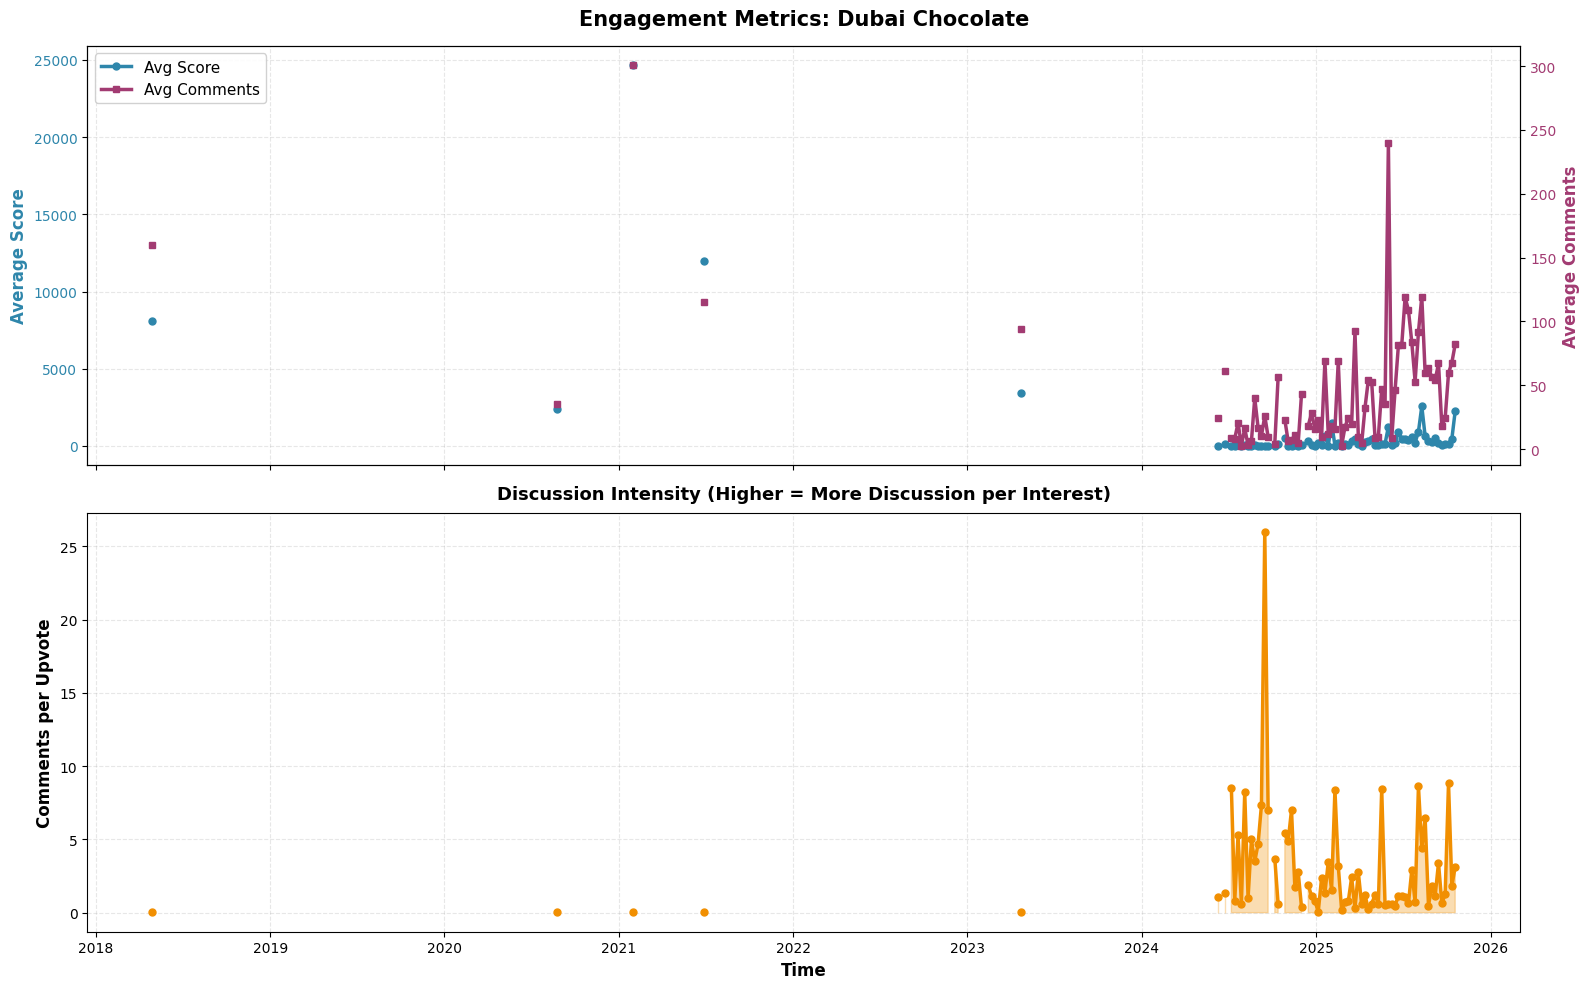

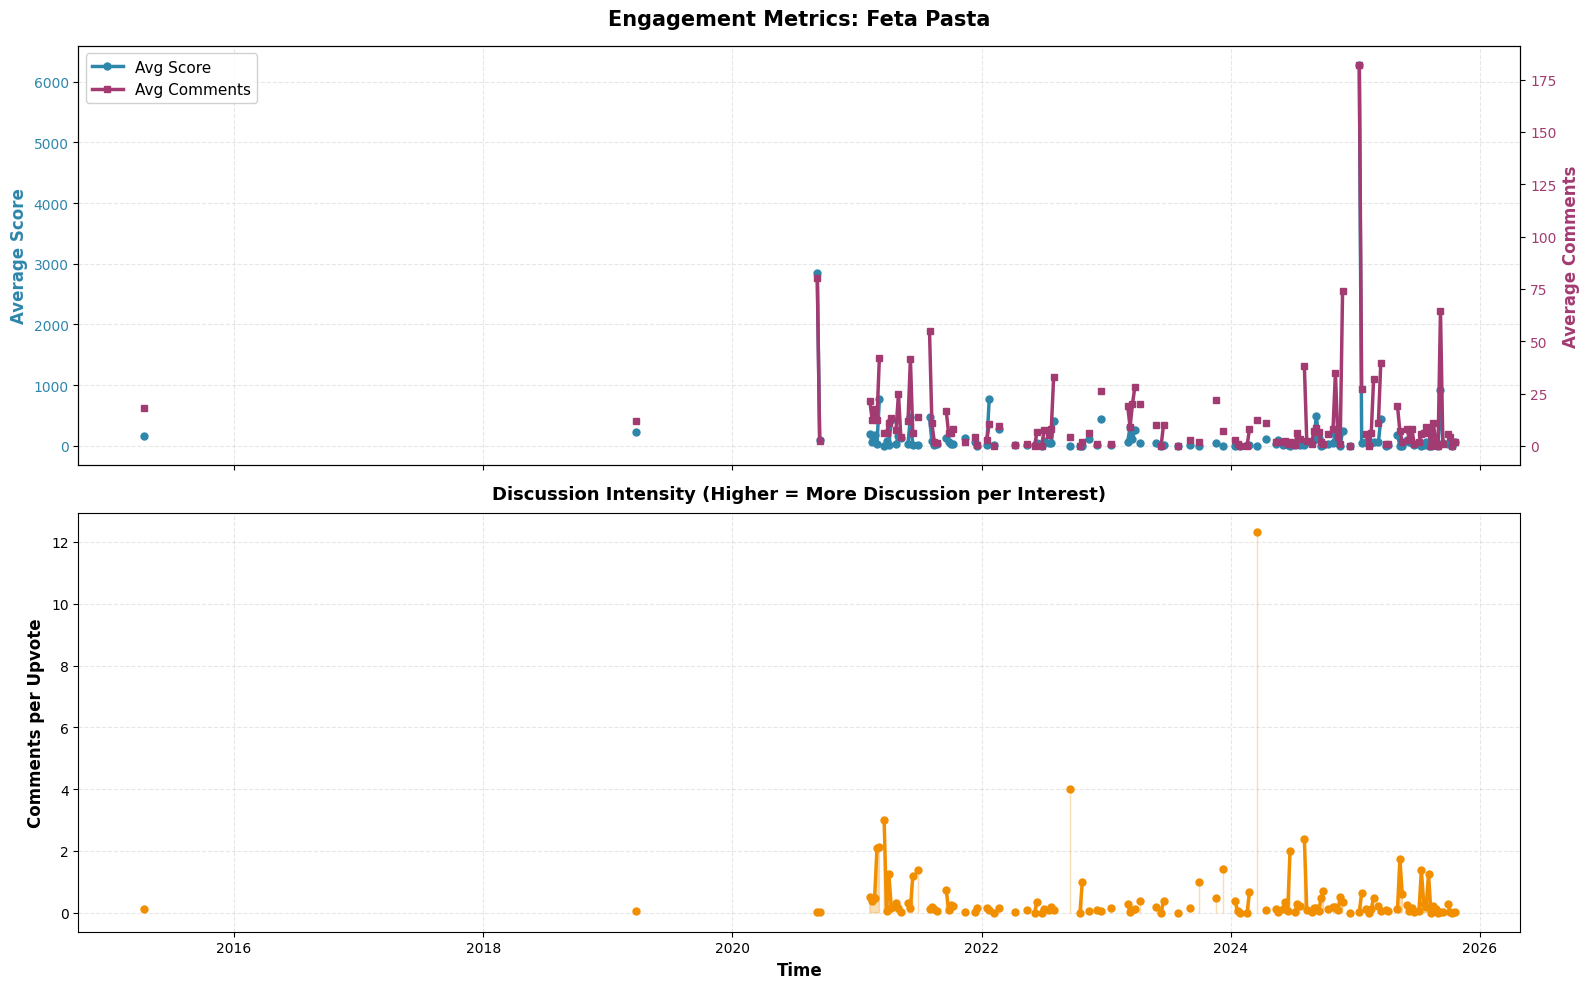

In [23]:
def plot_engagement_quality(df, trend_id='matcha'):
    """
    Shows how engagement quality changes as trend evolves
    """
    trend_df = df[df['Trend_ID'] == trend_id].copy()

    if len(trend_df) < 10:
        print(f"Not enough data for {trend_id}: only {len(trend_df)} posts")
        return

    # Calculate engagement ratio
    trend_df['engagement_ratio'] = (
        trend_df['num_comments'] / (trend_df['score'] + 1)
    )

    # Weekly aggregation
    weekly_engagement = (trend_df.set_index('Date')
                        .resample('W')
                        .agg({
                            'score': 'mean',
                            'num_comments': 'mean',
                            'engagement_ratio': 'mean'
                        })
                        .reset_index())

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

    # Top plot: Average score and comments
    ax1_twin = ax1.twinx()

    line1 = ax1.plot(weekly_engagement['Date'],
                     weekly_engagement['score'],
                     color='#2E86AB', linewidth=2.5, label='Avg Score',
                     marker='o', markersize=5)
    line2 = ax1_twin.plot(weekly_engagement['Date'],
                          weekly_engagement['num_comments'],
                          color='#A23B72', linewidth=2.5, label='Avg Comments',
                          marker='s', markersize=5)

    ax1.set_ylabel('Average Score', color='#2E86AB', fontsize=12, fontweight='bold')
    ax1_twin.set_ylabel('Average Comments', color='#A23B72', fontsize=12, fontweight='bold')
    ax1.tick_params(axis='y', labelcolor='#2E86AB')
    ax1_twin.tick_params(axis='y', labelcolor='#A23B72')
    ax1.set_title(f'Engagement Metrics: {trend_id.replace("-", " ").title()}',
                  fontsize=15, fontweight='bold', pad=15)
    ax1.grid(True, alpha=0.3, linestyle='--')

    # Combine legends
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper left', fontsize=11, framealpha=0.9)

    # Bottom plot: Engagement ratio
    ax2.plot(weekly_engagement['Date'],
             weekly_engagement['engagement_ratio'],
             color='#F18F01', linewidth=2.5, marker='o', markersize=5)
    ax2.fill_between(weekly_engagement['Date'],
                     weekly_engagement['engagement_ratio'],
                     alpha=0.3, color='#F18F01')
    ax2.set_xlabel('Time', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Comments per Upvote', fontsize=12, fontweight='bold')
    ax2.set_title('Discussion Intensity (Higher = More Discussion per Interest)',
                  fontsize=13, fontweight='bold', pad=10)
    ax2.grid(True, alpha=0.3, linestyle='--')
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

# Run for each major trend
for trend in ['matcha', 'dubai-chocolate', 'airfryer', 'feta-pasta']:
    if len(df[df['Trend_ID'] == trend]) >= 10:
        plot_engagement_quality(df, trend)


In [24]:
!pip install nltk wordcloud textblob vaderSentiment

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from collections import Counter
import re

In [25]:
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [26]:
analyzer = SentimentIntensityAnalyzer()

trends_to_analyze = ['dubai-chocolate', 'matcha', 'feta-pasta'] #removed air fryer as there are no posts pertaining to air fryer
df_trends = df[df['Trend_ID'].isin(trends_to_analyze)].copy()

print(f" Data prepared for sentiment analysis")
print(f"   Total posts: {len(df_trends)}")
print(f"   Breakdown by trend:")
for trend in trends_to_analyze:
    count = len(df_trends[df_trends['Trend_ID'] == trend])
    print(f"   • {trend}: {count} posts")

 Data prepared for sentiment analysis
   Total posts: 2178
   Breakdown by trend:
   • dubai-chocolate: 447 posts
   • matcha: 1441 posts
   • feta-pasta: 290 posts


In [27]:
def get_vader_sentiment(text):
    """
    Get VADER sentiment scores
    Returns: compound score (-1 to 1)
    """
    if pd.isna(text) or text == '':
        return 0
    scores = analyzer.polarity_scores(str(text))
    return scores['compound']

def classify_sentiment(compound_score):
    """
    Classify sentiment into categories
    """
    if compound_score >= 0.05:
        return 'Positive'
    elif compound_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

In [28]:
df_trends['sentiment_score'] = df_trends['title'].apply(get_vader_sentiment)
df_trends['sentiment_category'] = df_trends['sentiment_score'].apply(classify_sentiment)

print(f" Overall Sentiment Distribution:")
print(df_trends['sentiment_category'].value_counts())
print(f" Average Sentiment by Trend:")
for trend in trends_to_analyze:
    trend_df = df_trends[df_trends['Trend_ID'] == trend]
    avg_sentiment = trend_df['sentiment_score'].mean()
    print(f"   • {trend}: {avg_sentiment:.3f}")

 Overall Sentiment Distribution:
sentiment_category
Neutral     1469
Positive     488
Negative     221
Name: count, dtype: int64
 Average Sentiment by Trend:
   • dubai-chocolate: 0.016
   • matcha: 0.085
   • feta-pasta: 0.068


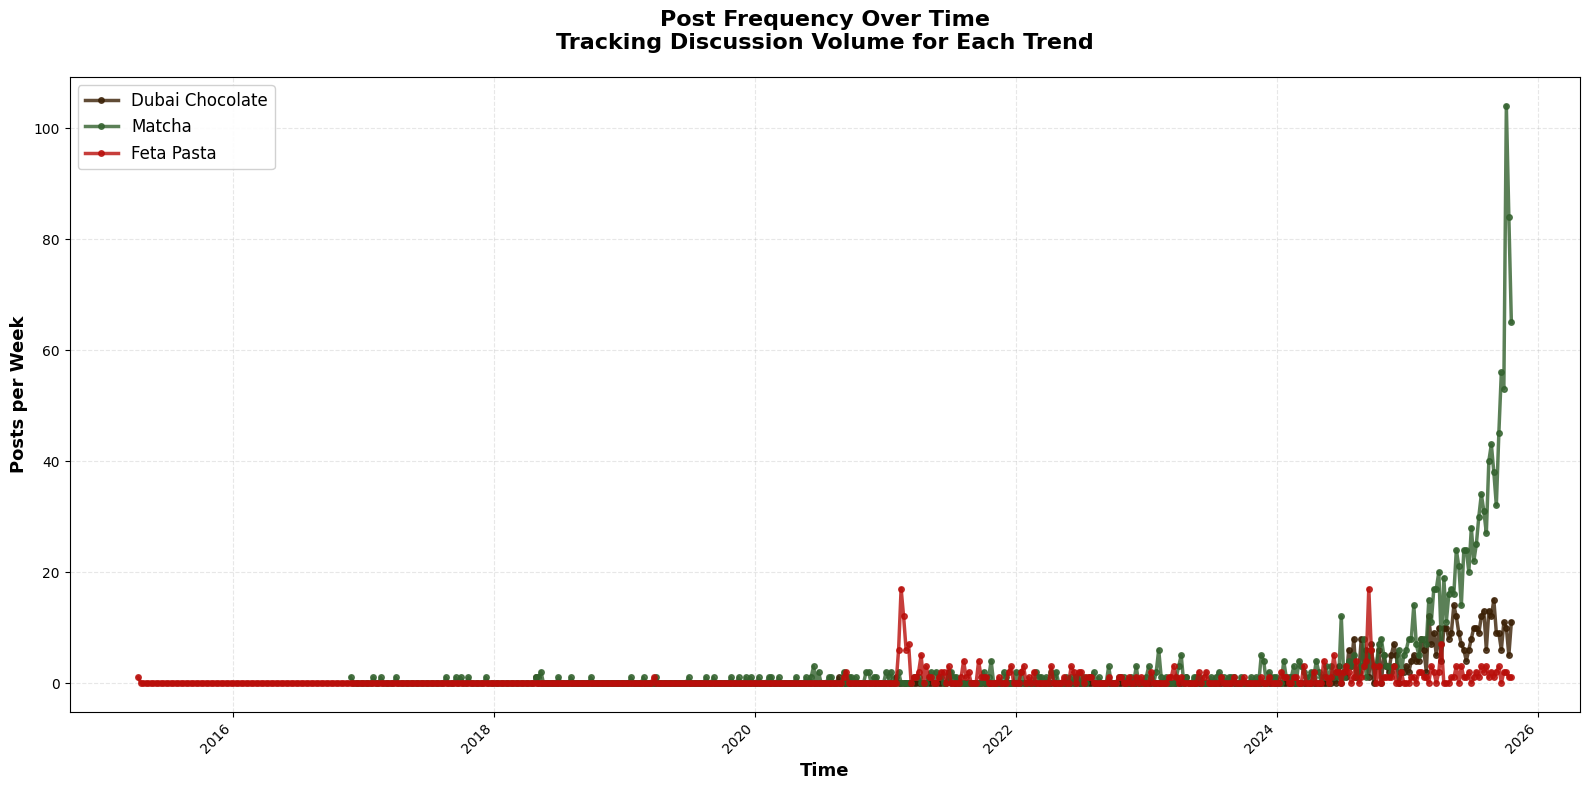

✓ Insight: Peaks show moments of viral hype or controversy


In [29]:
def plot_post_frequency_over_time(df_trends):
    """
    Track how often users discussed each trend
    """
    fig, ax = plt.subplots(figsize=(16, 8))

    for trend in trends_to_analyze:
        trend_df = df_trends[df_trends['Trend_ID'] == trend]

        if len(trend_df) < 5:
            continue

        # Weekly aggregation
        weekly_counts = (trend_df.set_index('Date')
                        .resample('W')
                        .size()
                        .reset_index(name='post_count'))

        ax.plot(weekly_counts['Date'],
               weekly_counts['post_count'],
               label=trend.replace('-', ' ').title(),
               color=CUSTOM_COLORS[trend],
               linewidth=2.5,
               marker='o',
               markersize=4,
               alpha=0.8)

    ax.set_xlabel('Time', fontsize=13, fontweight='bold')
    ax.set_ylabel('Posts per Week', fontsize=13, fontweight='bold')
    ax.set_title('Post Frequency Over Time\nTracking Discussion Volume for Each Trend',
                 fontsize=16, fontweight='bold', pad=20)
    ax.legend(fontsize=12, loc='best', framealpha=0.9)
    ax.grid(True, alpha=0.3, linestyle='--')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    print("✓ Insight: Peaks show moments of viral hype or controversy")

plot_post_frequency_over_time(df_trends)


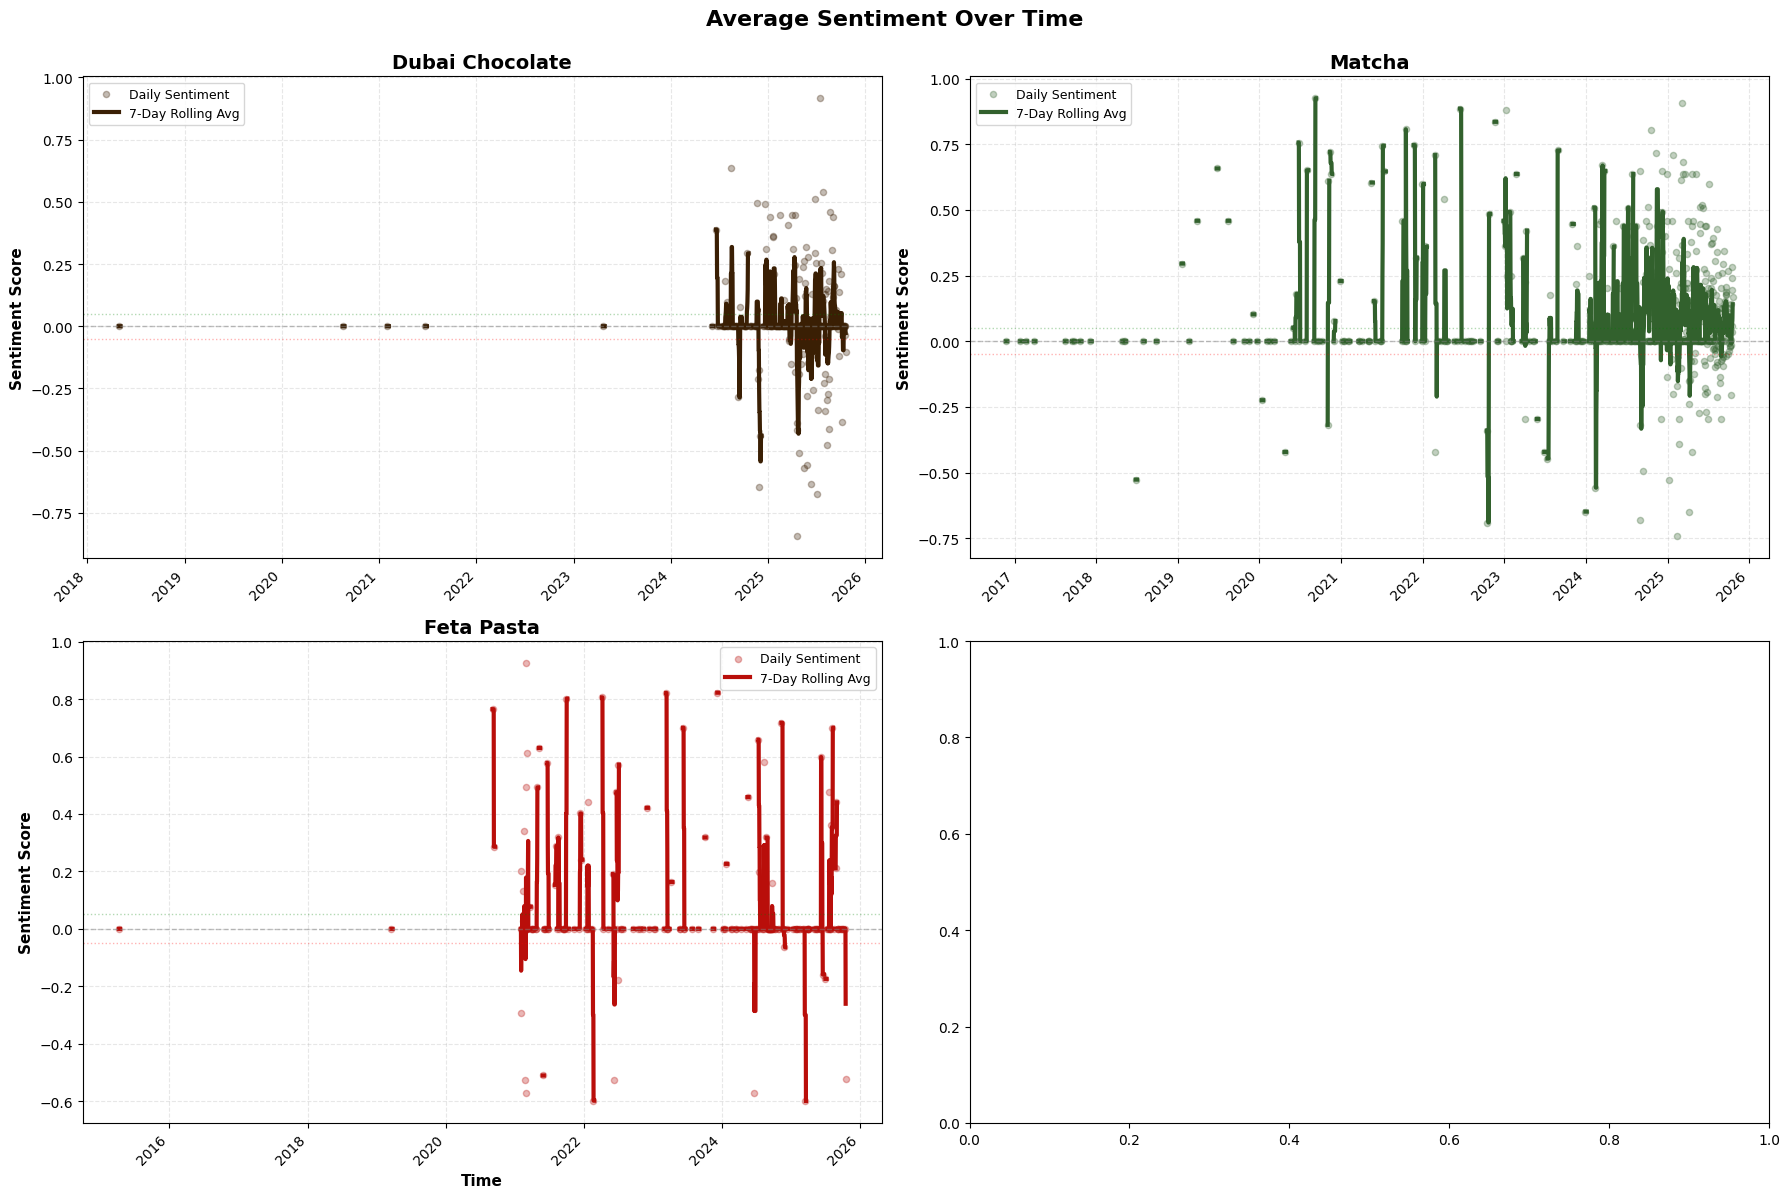

In [30]:
def plot_sentiment_over_time(df_trends):
    """
    Measure how user sentiment changes over time
    """
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    axes = axes.flatten()

    for idx, trend in enumerate(trends_to_analyze):
        trend_df = df_trends[df_trends['Trend_ID'] == trend].copy()

        if len(trend_df) < 10:
            axes[idx].text(0.5, 0.5, f'Insufficient data for {trend}',
                          ha='center', va='center', fontsize=12)
            axes[idx].set_title(trend.replace('-', ' ').title())
            continue

        # Daily sentiment average
        daily_sentiment = (trend_df.set_index('Date')
                          .resample('D')['sentiment_score']
                          .mean()
                          .reset_index())

        # Calculate 7-day rolling average
        daily_sentiment['rolling_avg'] = daily_sentiment['sentiment_score'].rolling(
            window=7, min_periods=1
        ).mean()

        # Plot raw sentiment (light)
        axes[idx].scatter(daily_sentiment['Date'],
                         daily_sentiment['sentiment_score'],
                         alpha=0.3, s=20, color=CUSTOM_COLORS[trend],
                         label='Daily Sentiment')

        # Plot rolling average (bold)
        axes[idx].plot(daily_sentiment['Date'],
                      daily_sentiment['rolling_avg'],
                      color=CUSTOM_COLORS[trend],
                      linewidth=3,
                      label='7-Day Rolling Avg')

        # Add reference lines
        axes[idx].axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
        axes[idx].axhline(y=0.05, color='green', linestyle=':', linewidth=1, alpha=0.3)
        axes[idx].axhline(y=-0.05, color='red', linestyle=':', linewidth=1, alpha=0.3)

        axes[idx].set_title(trend.replace('-', ' ').title(),
                           fontsize=14, fontweight='bold')
        axes[idx].set_ylabel('Sentiment Score', fontsize=11, fontweight='bold')
        axes[idx].grid(True, alpha=0.3, linestyle='--')
        axes[idx].legend(fontsize=9)

        if idx >= 2:
            axes[idx].set_xlabel('Time', fontsize=11, fontweight='bold')

        plt.setp(axes[idx].xaxis.get_majorticklabels(), rotation=45, ha='right')

    fig.suptitle('Average Sentiment Over Time',
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

plot_sentiment_over_time(df_trends)



/tmp/ipython-input-1722872900.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot(sentiment_data,


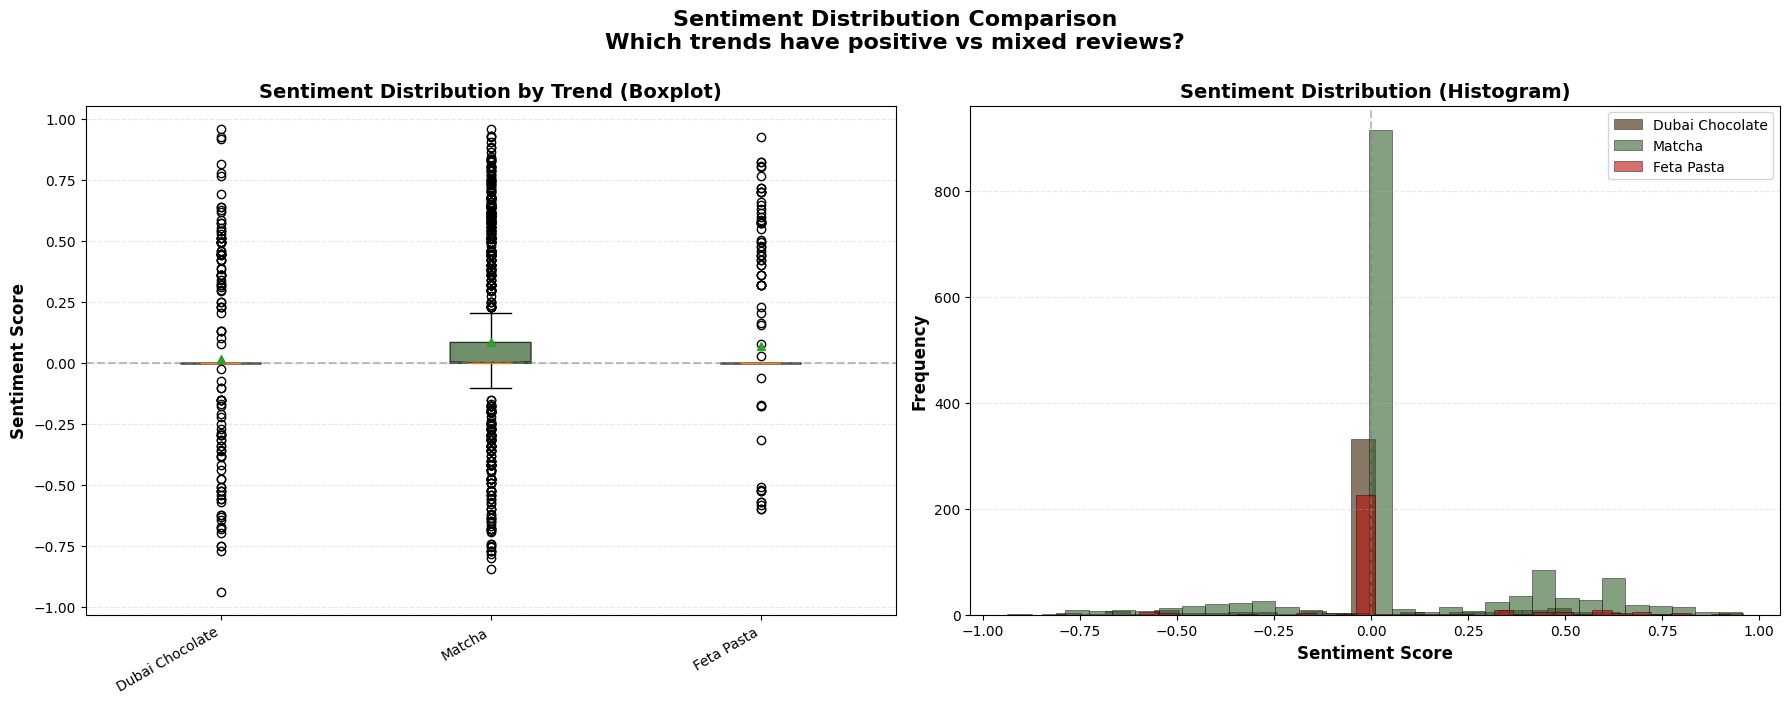

In [31]:
def plot_sentiment_distribution(df_trends):
    """
    Compare general emotional tone across trends
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

    # BOXPLOT
    sentiment_data = [df_trends[df_trends['Trend_ID'] == trend]['sentiment_score'].dropna()
                     for trend in trends_to_analyze]

    bp = ax1.boxplot(sentiment_data,
                     labels=[t.replace('-', ' ').title() for t in trends_to_analyze],
                     patch_artist=True,
                     notch=True,
                     showmeans=True)

    # Color the boxes
    for patch, trend in zip(bp['boxes'], trends_to_analyze):
        patch.set_facecolor(CUSTOM_COLORS[trend])
        patch.set_alpha(0.7)

    ax1.axhline(y=0, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)
    ax1.set_ylabel('Sentiment Score', fontsize=12, fontweight='bold')
    ax1.set_title('Sentiment Distribution by Trend (Boxplot)',
                  fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y', linestyle='--')
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=30, ha='right')

    # HISTOGRAM
    for trend in trends_to_analyze:
        trend_df = df_trends[df_trends['Trend_ID'] == trend]
        ax2.hist(trend_df['sentiment_score'],
                bins=30,
                alpha=0.6,
                label=trend.replace('-', ' ').title(),
                color=CUSTOM_COLORS[trend],
                edgecolor='black',
                linewidth=0.5)

    ax2.axvline(x=0, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)
    ax2.set_xlabel('Sentiment Score', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax2.set_title('Sentiment Distribution (Histogram)',
                  fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3, axis='y', linestyle='--')

    fig.suptitle('Sentiment Distribution Comparison\nWhich trends have positive vs mixed reviews?',
                 fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

plot_sentiment_distribution(df_trends)

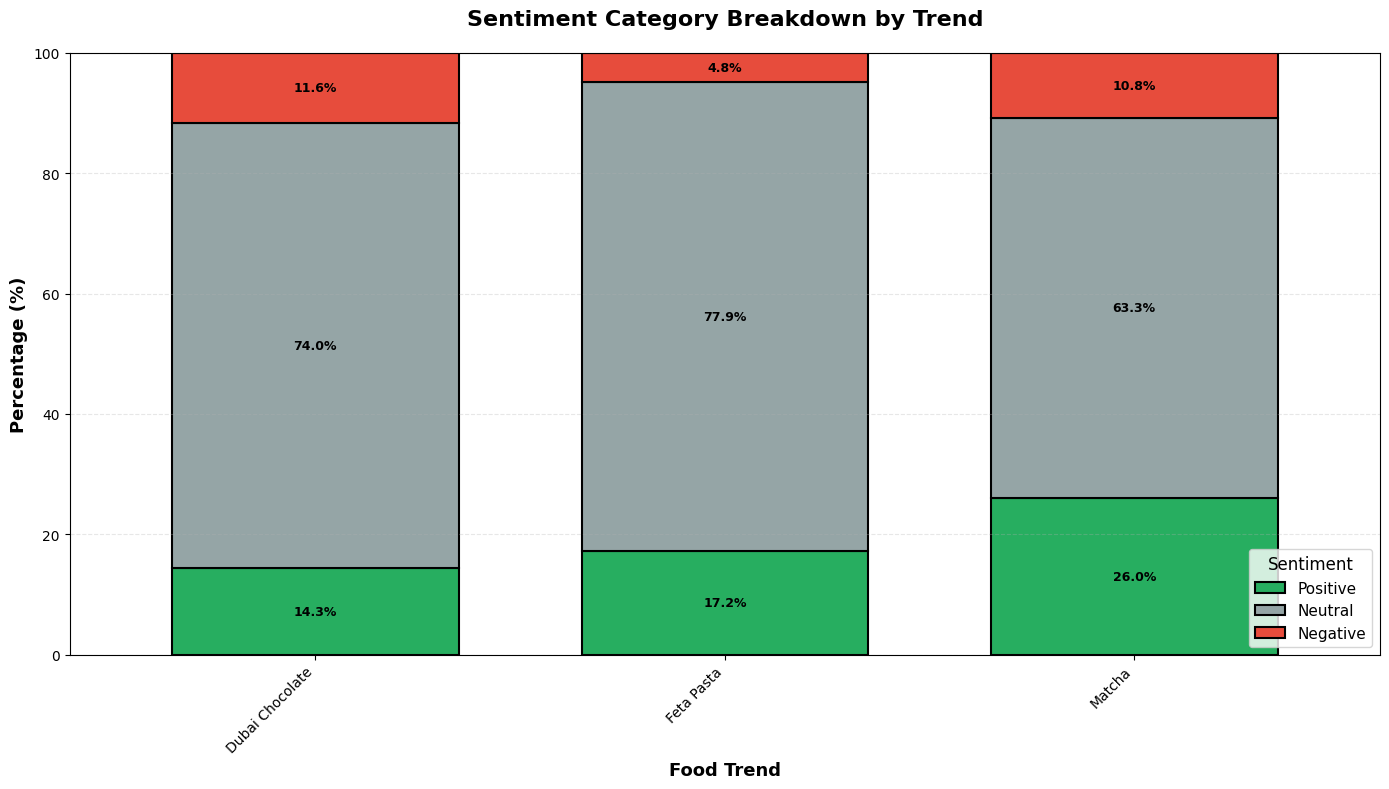

In [32]:
def plot_sentiment_category_breakdown(df_trends):
    """
    Show proportion of positive/neutral/negative for each trend
    """
    fig, ax = plt.subplots(figsize=(14, 8))

    # Calculate percentages
    sentiment_breakdown = df_trends.groupby(['Trend_ID', 'sentiment_category']).size().unstack(fill_value=0)
    sentiment_pct = sentiment_breakdown.div(sentiment_breakdown.sum(axis=1), axis=0) * 100

    # Reorder for better visualization
    sentiment_pct = sentiment_pct[['Positive', 'Neutral', 'Negative']]

    # Rename index for display
    sentiment_pct.index = [t.replace('-', ' ').title() for t in sentiment_pct.index]

    # Plot stacked bar
    sentiment_pct.plot(kind='bar',
                       stacked=True,
                       ax=ax,
                       color=['#27AE60', '#95A5A6', '#E74C3C'],
                       width=0.7,
                       edgecolor='black',
                       linewidth=1.5)

    ax.set_ylabel('Percentage (%)', fontsize=13, fontweight='bold')
    ax.set_xlabel('Food Trend', fontsize=13, fontweight='bold')
    ax.set_title('Sentiment Category Breakdown by Trend',
                 fontsize=16, fontweight='bold', pad=20)
    ax.legend(title='Sentiment', fontsize=11, title_fontsize=12)
    ax.set_ylim(0, 100)
    plt.xticks(rotation=45, ha='right')
    ax.grid(True, alpha=0.3, axis='y', linestyle='--')

    # Add percentage labels
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', label_type='center', fontsize=9, weight='bold')

    plt.tight_layout()
    plt.show()


plot_sentiment_category_breakdown(df_trends)


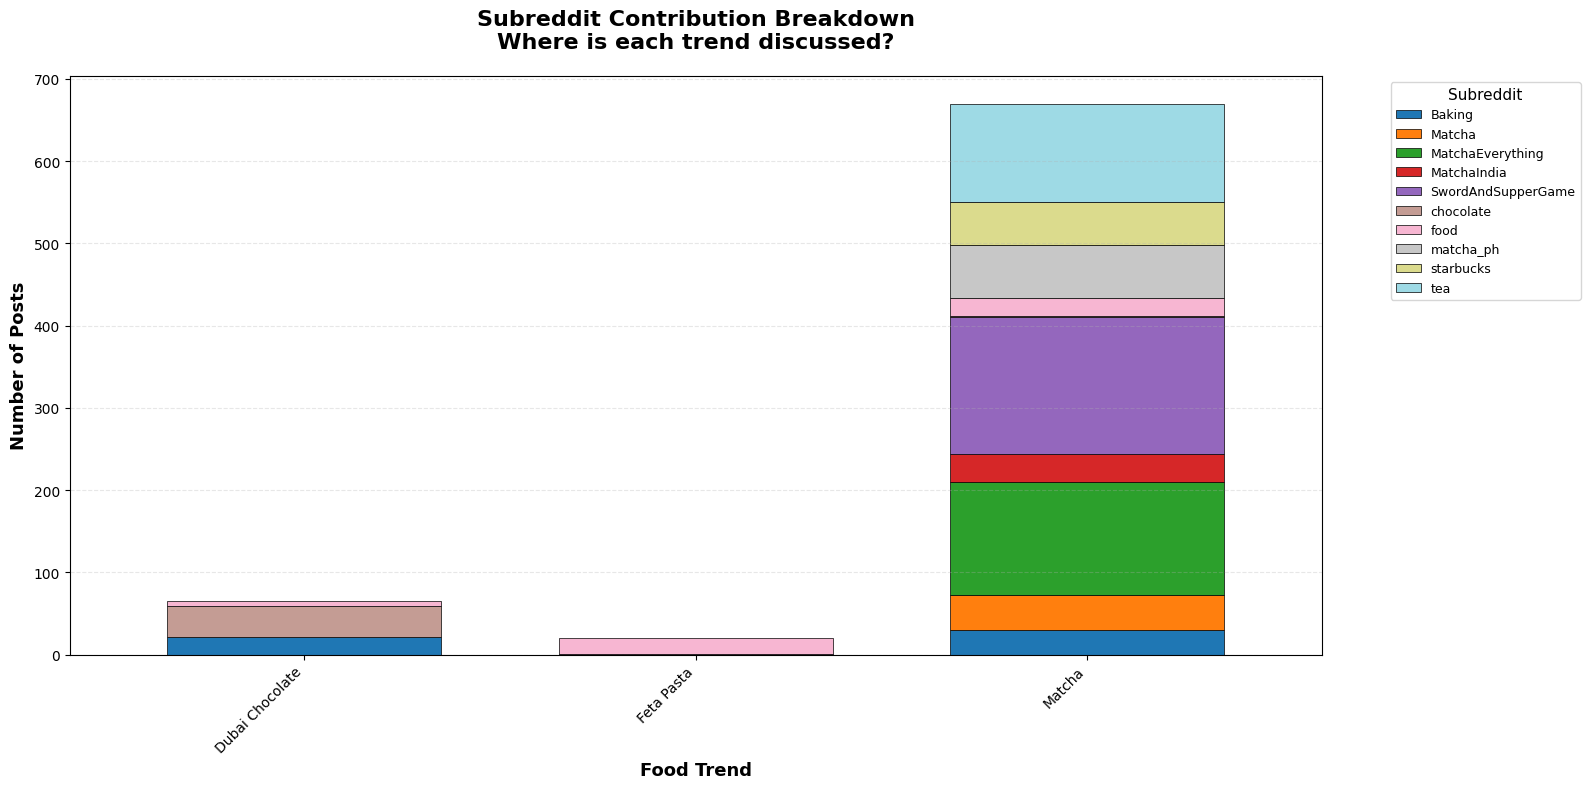

✓ Insight: Reveals where discussion lives (r/Food, r/Cooking, etc.)


In [33]:
def plot_subreddit_breakdown(df_trends):
    """
    Show which subreddits talk about each trend
    """
    fig, ax = plt.subplots(figsize=(16, 8))

    # Get top 10 subreddits overall
    top_subs = df_trends['subreddit'].value_counts().head(10).index

    # Create pivot table
    sub_breakdown = df_trends[df_trends['subreddit'].isin(top_subs)].groupby(
        ['Trend_ID', 'subreddit']
    ).size().unstack(fill_value=0)

    # Rename for display
    sub_breakdown.index = [t.replace('-', ' ').title() for t in sub_breakdown.index]

    # Plot stacked bar
    sub_breakdown.plot(kind='bar',
                       stacked=True,
                       ax=ax,
                       colormap='tab20',
                       width=0.7,
                       edgecolor='black',
                       linewidth=0.5)

    ax.set_ylabel('Number of Posts', fontsize=13, fontweight='bold')
    ax.set_xlabel('Food Trend', fontsize=13, fontweight='bold')
    ax.set_title('Subreddit Contribution Breakdown\nWhere is each trend discussed?',
                 fontsize=16, fontweight='bold', pad=20)
    ax.legend(title='Subreddit', fontsize=9, title_fontsize=11,
             bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45, ha='right')
    ax.grid(True, alpha=0.3, axis='y', linestyle='--')

    plt.tight_layout()
    plt.show()

    print("✓ Insight: Reveals where discussion lives (r/Food, r/Cooking, etc.)")

plot_subreddit_breakdown(df_trends)

In [34]:
def plot_word_clouds_fixed(df_trends):
    """
    Show most frequent terms in posts for each trend - FIXED VERSION
    """
    import matplotlib.pyplot as plt
    from wordcloud import WordCloud
    from nltk.corpus import stopwords
    import re

    # Define colors locally if not defined globally
    CUSTOM_COLORS_LOCAL = {
        'dubai-chocolate': '#3A1F04',
        'feta-pasta': '#B90E0A',
        'matcha': '#32612D'
    }

    # Prepare stopwords
    stop_words = set(stopwords.words('english'))
    # Add custom food-related stopwords and trend-specific terms
    custom_stops = {
        'recipe', 'food', 'make', 'made', 'anyone', 'like', 'get',
        'want', 'try', 'help', 'know', 'one', 'good', 'best', 'first',
        'time', 'new', 'would', 'could', 'really', 'much', 'also',
        'just', 'got', 'way', 'thing', 'things', 'need', 'use', 'ive',
        'dont', 'cant', 'wont', 'didnt', 'doesnt', 'im', 'youre',
        # Add trend names and components as stopwords
        'dubai', 'chocolate', 'matcha', 'feta', 'pasta', 'cheese',
        'tomato', 'viral', 'tiktok', 'baked', 'green', 'tea'
    }
    stop_words.update(custom_stops)

    # Only analyze trends with data (excluding air-fryer)
    trends_to_analyze_fixed = ['dubai-chocolate', 'matcha', 'feta-pasta']

    # Count how many trends have sufficient data
    valid_trends = []
    for trend in trends_to_analyze_fixed:
        if len(df_trends[df_trends['Trend_ID'] == trend]) >= 10:
            valid_trends.append(trend)

    if len(valid_trends) == 0:
        print("⚠️ No trends have sufficient data for word clouds")
        return

    # Create subplots based on number of valid trends
    fig, axes = plt.subplots(1, len(valid_trends), figsize=(7*len(valid_trends), 6))
    if len(valid_trends) == 1:
        axes = [axes]

    for idx, trend in enumerate(valid_trends):
        trend_df = df_trends[df_trends['Trend_ID'] == trend]

        print(f"\nProcessing {trend}:")
        print(f"  - Number of posts: {len(trend_df)}")

        # Combine all titles, handling NaN values
        titles = trend_df['title'].dropna().astype(str).tolist()
        text = ' '.join(titles)

        # Clean text more thoroughly
        text = re.sub(r'http\S+', '', text)  # Remove URLs
        text = re.sub(r'www\.\S+', '', text)  # Remove www.
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)  # Replace non-letters with spaces
        text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
        text = text.lower().strip()

        # Remove single and two-letter words
        words = text.split()
        words = [w for w in words if len(w) > 2 and w not in stop_words]
        cleaned_text = ' '.join(words)

        print(f"  - Text length after cleaning: {len(cleaned_text)} characters")
        print(f"  - Number of words: {len(words)}")

        if len(cleaned_text) < 50 or len(words) < 20:
            axes[idx].text(0.5, 0.5,
                          f'Insufficient text for {trend}\n({len(words)} words after cleaning)',
                          ha='center', va='center', fontsize=12)
            axes[idx].axis('off')
            axes[idx].set_title(trend.replace('-', ' ').title(),
                               fontsize=14, fontweight='bold')
            continue

        try:
            # Choose colormap based on trend
            colormap_options = {
                'dubai-chocolate': 'copper',
                'matcha': 'Greens',
                'feta-pasta': 'Reds'
            }

            # Generate word cloud
            wordcloud = WordCloud(
                width=800,
                height=400,
                background_color='white',
                stopwords=stop_words,
                colormap=colormap_options.get(trend, 'viridis'),
                max_words=60,
                relative_scaling=0.6,
                min_font_size=14,
                max_font_size=100,
                prefer_horizontal=0.7,
                random_state=42,
                collocations=False  # Avoid repeated word pairs
            ).generate(cleaned_text)

            axes[idx].imshow(wordcloud, interpolation='bilinear')
            axes[idx].axis('off')
            axes[idx].set_title(trend.replace('-', ' ').title(),
                               fontsize=14, fontweight='bold', pad=10,
                               color=CUSTOM_COLORS_LOCAL.get(trend, 'black'))

            # Print top words for verification
            word_freq = wordcloud.words_
            top_5 = list(word_freq.keys())[:5]
            print(f"  - Top 5 words: {', '.join(top_5)}")

        except Exception as e:
            print(f"  ❌ Error generating wordcloud: {e}")
            axes[idx].text(0.5, 0.5, f'Error generating wordcloud\nfor {trend}',
                          ha='center', va='center', fontsize=12)
            axes[idx].axis('off')
            axes[idx].set_title(trend.replace('-', ' ').title(),
                               fontsize=14, fontweight='bold')

    fig.suptitle('☁️ Word Clouds: Most Common Terms by Trend\nRevealing the "language" of each trend',
                fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

    print("\n✓ Word cloud generation complete!")
    print("✓ Insight: Shows the dominant vocabulary and topics for each trend")

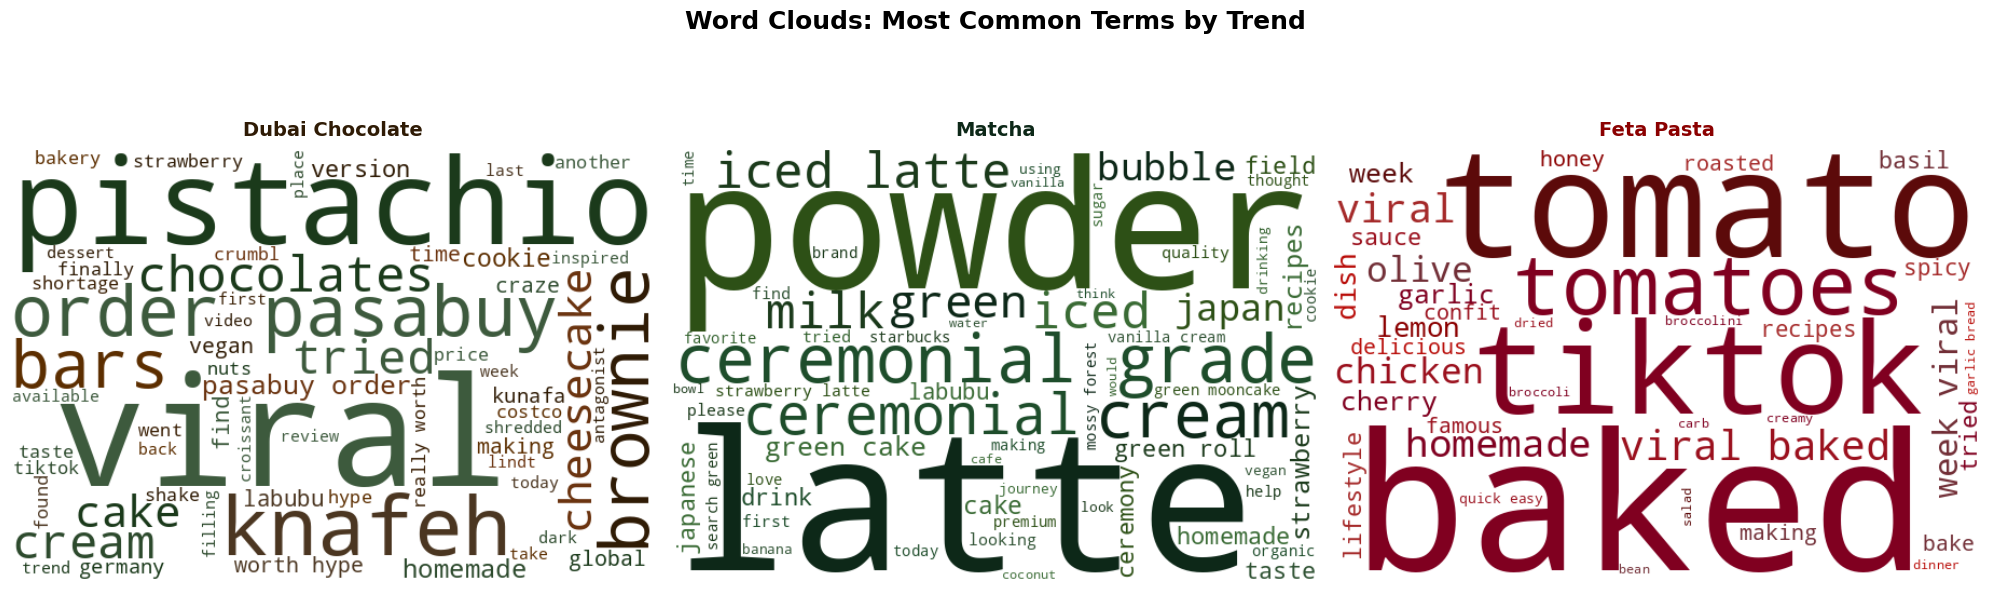

In [41]:
def plot_word_clouds_dark_colors(df_trends):
    """
    Word clouds with darker, more saturated colors for each trend
    """
    from wordcloud import WordCloud
    from nltk.corpus import stopwords
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    import numpy as np
    import re

    # Create custom color functions for darker shades
    def dark_brown_green_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        """Custom color function for Dubai Chocolate - dark browns and greens"""
        colors = [
            '#2F1B05',  # Very dark brown
            '#3A1F04',  # Dark brown
            '#5C2E00',  # Chocolate brown
            '#6B3410',  # Medium brown
            '#1B3A1B',  # Dark forest green
            '#2D4A2D',  # Deep green
            '#3D5A3D',  # Medium dark green
            '#4B3621',  # Brown-green mix
        ]
        return np.random.choice(colors)

    def dark_green_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        """Custom color function for Matcha - dark greens"""
        colors = [
            '#0D2818',  # Very dark green
            '#1B3A1B',  # Dark forest green
            '#2D5016',  # Deep green
            '#32612D',  # Matcha green
            '#3A6B35',  # Medium dark green
            '#2F5233',  # Dark sage green
            '#1E4D2B',  # Pine green
        ]
        return np.random.choice(colors)

    def dark_red_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        """Custom color function for Feta Pasta - dark reds"""
        colors = [
            '#5C0A0A',  # Very dark red
            '#8B0000',  # Dark red
            '#B90E0A',  # Medium dark red
            '#A52A2A',  # Red brown
            '#800020',  # Burgundy
            '#722F37',  # Wine red
            '#9B111E',  # Ruby red
        ]
        return np.random.choice(colors)

    # Use the same figure setup
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))

    # Define title colors (darker versions)
    TITLE_COLORS = {
        'dubai-chocolate': '#2F1B05',  # Very dark brown
        'feta-pasta': '#8B0000',       # Dark red
        'matcha': '#0D2818'            # Very dark green
    }

    # Basic stopwords
    stop_words = set(stopwords.words('english'))
    stop_words.update(['recipe', 'food', 'make', 'made', 'dubai', 'chocolate',
                      'matcha', 'feta', 'pasta', 'cheese', 'anyone', 'get',
                      'want', 'try', 'one', 'like', 'good', 'best', 'know'])

    trends_to_analyze = ['dubai-chocolate', 'matcha', 'feta-pasta']

    # Store color functions for each trend
    color_functions = {
        'dubai-chocolate': dark_brown_green_color_func,
        'matcha': dark_green_color_func,
        'feta-pasta': dark_red_color_func
    }

    for idx, trend in enumerate(trends_to_analyze):
        trend_df = df_trends[df_trends['Trend_ID'] == trend]

        if len(trend_df) < 10:
            axes[idx].text(0.5, 0.5, f'Insufficient data for {trend}',
                          ha='center', va='center', fontsize=12)
            axes[idx].set_title(trend.replace('-', ' ').title())
            axes[idx].axis('off')
            continue

        # Prepare text
        text = ' '.join(trend_df['title'].dropna().astype(str).values)
        text = re.sub(r'[^a-zA-Z\s]', ' ', text.lower())
        words = [w for w in text.split() if len(w) > 3 and w not in stop_words]
        text = ' '.join(words)

        if len(text) < 100:
            axes[idx].text(0.5, 0.5, 'Not enough text',
                          ha='center', va='center', fontsize=12)
            axes[idx].set_title(trend.replace('-', ' ').title())
            axes[idx].axis('off')
            continue

        # Create word cloud with custom color function
        wc = WordCloud(
            width=600,
            height=400,
            background_color='white',
            max_words=60,
            stopwords=stop_words,
            relative_scaling=0.5,
            min_font_size=12,
            random_state=42
        ).generate(text)

        # Apply custom color function
        wc.recolor(color_func=color_functions[trend])

        # Display using imshow
        axes[idx].imshow(wc, interpolation='bilinear')
        axes[idx].set_title(trend.replace('-', ' ').title(),
                           fontsize=14, fontweight='bold',
                           color=TITLE_COLORS[trend],
                           pad=10)
        axes[idx].axis('off')

    fig.suptitle('Word Clouds: Most Common Terms by Trend',
                 fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()


# Run it
plot_word_clouds_dark_colors(df_trends)


/tmp/ipython-input-551771698.py:57: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


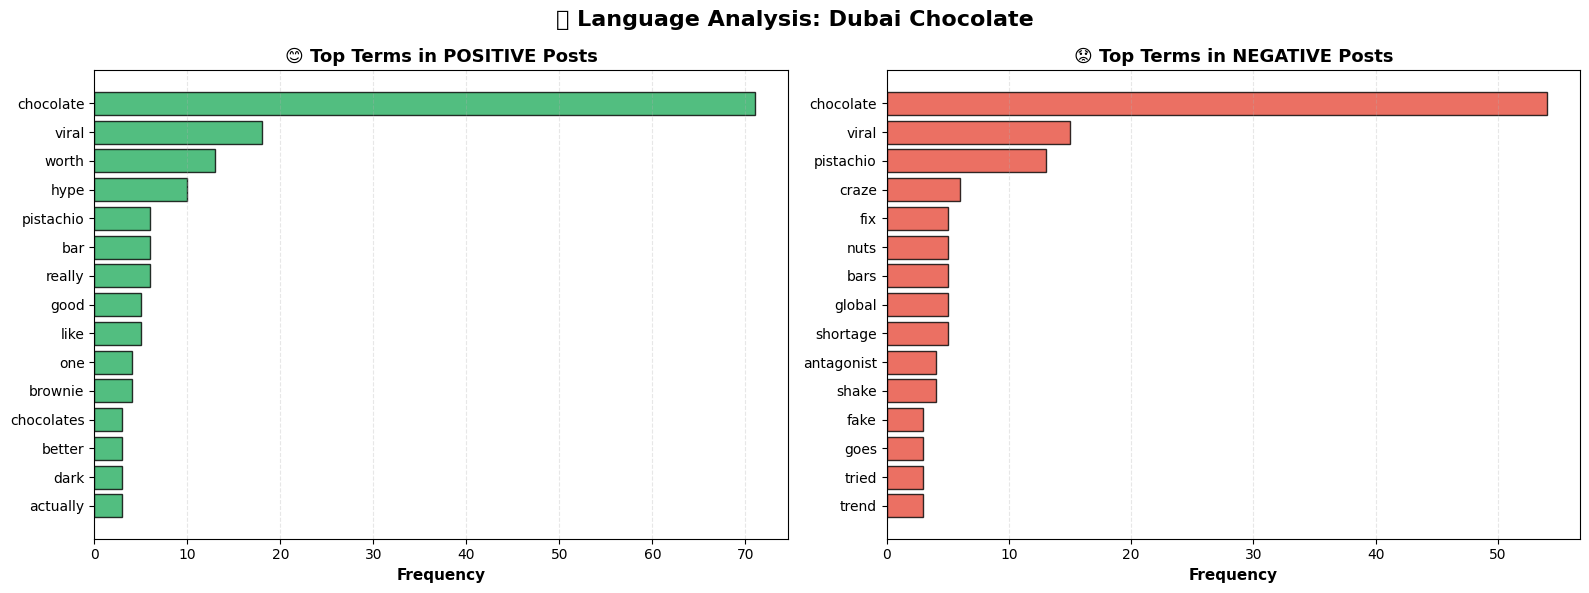

✓ Insight: Shows what language defines positive vs negative posts


/tmp/ipython-input-551771698.py:57: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


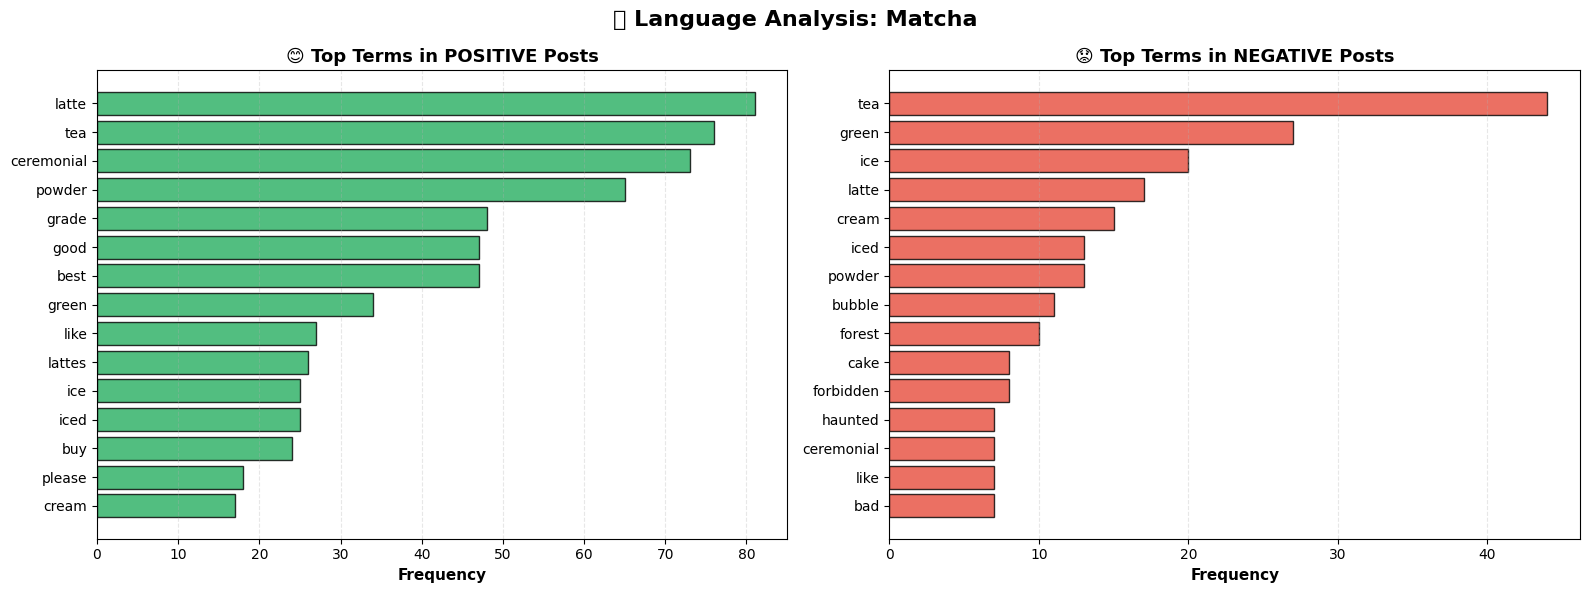

✓ Insight: Shows what language defines positive vs negative posts


/tmp/ipython-input-551771698.py:57: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


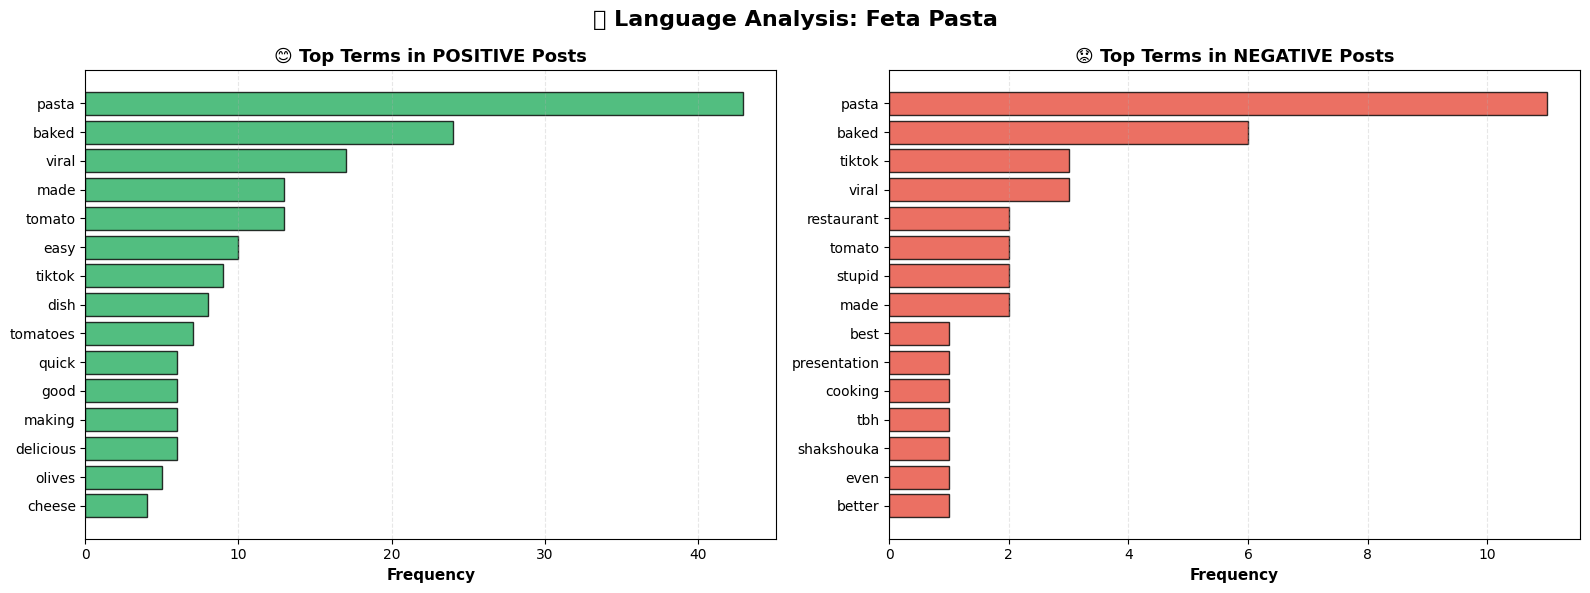

✓ Insight: Shows what language defines positive vs negative posts


In [36]:
def plot_top_terms_by_sentiment(df_trends, trend_id='matcha'):
    """
    Show what words appear in positive vs negative posts
    """
    trend_df = df_trends[df_trends['Trend_ID'] == trend_id].copy()

    if len(trend_df) < 20:
        print(f"⚠️ Not enough data for {trend_id}")
        return

    # Prepare stopwords
    stop_words = set(stopwords.words('english'))
    custom_stops = {'recipe', 'food', trend_id.replace('-', ' ').split()[0]}
    stop_words.update(custom_stops)

    # Split by sentiment
    positive_posts = trend_df[trend_df['sentiment_category'] == 'Positive']['title']
    negative_posts = trend_df[trend_df['sentiment_category'] == 'Negative']['title']

    def get_top_words(texts, n=15):
        all_words = []
        for text in texts:
            words = re.findall(r'\b[a-z]{3,}\b', str(text).lower())
            all_words.extend([w for w in words if w not in stop_words])
        return Counter(all_words).most_common(n)

    pos_words = get_top_words(positive_posts)
    neg_words = get_top_words(negative_posts)

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Positive words
    if pos_words:
        words, counts = zip(*pos_words)
        ax1.barh(range(len(words)), counts, color='#27AE60', alpha=0.8, edgecolor='black')
        ax1.set_yticks(range(len(words)))
        ax1.set_yticklabels(words)
        ax1.invert_yaxis()
        ax1.set_xlabel('Frequency', fontsize=11, fontweight='bold')
        ax1.set_title('😊 Top Terms in POSITIVE Posts', fontsize=13, fontweight='bold')
        ax1.grid(True, alpha=0.3, axis='x', linestyle='--')

    # Negative words
    if neg_words:
        words, counts = zip(*neg_words)
        ax2.barh(range(len(words)), counts, color='#E74C3C', alpha=0.8, edgecolor='black')
        ax2.set_yticks(range(len(words)))
        ax2.set_yticklabels(words)
        ax2.invert_yaxis()
        ax2.set_xlabel('Frequency', fontsize=11, fontweight='bold')
        ax2.set_title('😟 Top Terms in NEGATIVE Posts', fontsize=13, fontweight='bold')
        ax2.grid(True, alpha=0.3, axis='x', linestyle='--')

    fig.suptitle(f'📝 Language Analysis: {trend_id.replace("-", " ").title()}',
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print(f"✓ Insight: Shows what language defines positive vs negative posts")

# Run for each trend
for trend in trends_to_analyze:
    plot_top_terms_by_sentiment(df_trends, trend)

In [37]:
print("\n" + "="*80)
print("📊 SENTIMENT ANALYSIS SUMMARY")
print("="*80)

for trend in trends_to_analyze:
    trend_df = df_trends[df_trends['Trend_ID'] == trend]

    print(f"\n🔹 {trend.replace('-', ' ').title()}")
    print(f"   Total Posts: {len(trend_df)}")
    print(f"   Avg Sentiment: {trend_df['sentiment_score'].mean():.3f}")
    print(f"   Sentiment Distribution:")
    print(f"      • Positive: {(trend_df['sentiment_category'] == 'Positive').sum()} ({(trend_df['sentiment_category'] == 'Positive').sum()/len(trend_df)*100:.1f}%)")
    print(f"      • Neutral:  {(trend_df['sentiment_category'] == 'Neutral').sum()} ({(trend_df['sentiment_category'] == 'Neutral').sum()/len(trend_df)*100:.1f}%)")
    print(f"      • Negative: {(trend_df['sentiment_category'] == 'Negative').sum()} ({(trend_df['sentiment_category'] == 'Negative').sum()/len(trend_df)*100:.1f}%)")

    # Engagement by sentiment
    for sentiment in ['Positive', 'Neutral', 'Negative']:
        sentiment_df = trend_df[trend_df['sentiment_category'] == sentiment]
        if len(sentiment_df) > 0:
            avg_score = sentiment_df['score'].mean()
            avg_comments = sentiment_df['num_comments'].mean()
            print(f"   {sentiment} Posts → Avg Score: {avg_score:.1f}, Avg Comments: {avg_comments:.1f}")



📊 SENTIMENT ANALYSIS SUMMARY

🔹 Dubai Chocolate
   Total Posts: 447
   Avg Sentiment: 0.016
   Sentiment Distribution:
      • Positive: 64 (14.3%)
      • Neutral:  331 (74.0%)
      • Negative: 52 (11.6%)
   Positive Posts → Avg Score: 344.8, Avg Comments: 54.8
   Neutral Posts → Avg Score: 485.5, Avg Comments: 40.7
   Negative Posts → Avg Score: 615.8, Avg Comments: 90.9

🔹 Matcha
   Total Posts: 1441
   Avg Sentiment: 0.085
   Sentiment Distribution:
      • Positive: 374 (26.0%)
      • Neutral:  912 (63.3%)
      • Negative: 155 (10.8%)
   Positive Posts → Avg Score: 411.0, Avg Comments: 28.5
   Neutral Posts → Avg Score: 748.2, Avg Comments: 51.2
   Negative Posts → Avg Score: 631.1, Avg Comments: 51.6

🔹 Feta Pasta
   Total Posts: 290
   Avg Sentiment: 0.068
   Sentiment Distribution:
      • Positive: 50 (17.2%)
      • Neutral:  226 (77.9%)
      • Negative: 14 (4.8%)
   Positive Posts → Avg Score: 112.6, Avg Comments: 8.0
   Neutral Posts → Avg Score: 144.5, Avg Comments: 1